In [9]:
# PROJECT SETUP
# notes: use inplace=True when dropping if you want to apply changes to the current dataframe

# imports
import sys
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import IPython as ip
from IPython import display as display
import seaborn as sns
import sklearn as sk
import random
import time

# package versions and data input
print("-"*20)
print("python:\t\t {}". format(sys.version))
print("pandas:\t\t {}". format(pd.__version__))
print("matplotlib:\t {}". format(mpl.__version__))
print("numpy:\t\t {}". format(np.__version__))
print("ipython:\t {}". format(ip.__version__))
print("seaborn:\t {}". format(sns.__version__))
print("sklearn:\t {}". format(sk.__version__))
print("-"*20)
from subprocess import check_output
print(check_output(["ls", "../data"]).decode("utf8"))
print("-"*20)

--------------------
python:		 3.7.9 (default, Aug 31 2020, 12:42:55) 
[GCC 7.3.0]
pandas:		 1.1.3
matplotlib:	 3.3.2
numpy:		 1.18.1
ipython:	 7.18.1
seaborn:	 0.11.0
sklearn:	 0.23.2
--------------------
ks2016.csv
ks2018.csv
notebook.ipynb

--------------------


In [10]:
# DATA

# import data
data = pd.read_csv('ks2018.csv')

# number of samples
print('The number of samples the data set is {}.'.format(data.shape[0]))
print("-"*20)

# null data
print('The data set has the following amount of null values')
print(data.isnull().sum())
print('Percentage missing for "name" %.4f%%' %((data['name'].isnull().sum()/data.shape[0])*100))
print('Percentage missing for "usd pledged" %.4f%%' %((data['usd pledged'].isnull().sum()/data.shape[0])*100))
print("-"*20)

# possible outcomes
print('The following outcomes are possible')
print(data.state.unique())
print("-"*20)

# possible categories
print('The following project categories exist')
print(data.main_category.unique())
print("-"*20)

# possible currencies
print('The following currencies exist')
print(data.currency.unique())
print("-"*20)

# possible countries
print('The following countries exist')
print(data.country.unique())
print("-"*20)

# live projects
live = data.apply(lambda x: True if x['state'] == 'live' else False , axis=1)
liveAmount = len(live[live == True].index)
print('The amount of live projects is: ', liveAmount)
print('This is %.2f%% of the total projects' %((liveAmount/data.shape[0])*100))
print("-"*20)

data.describe(include = 'all')


The number of samples the data set is 378661.
--------------------
The data set has the following amount of null values
ID                     0
name                   4
category               0
main_category          0
currency               0
deadline               0
goal                   0
launched               0
pledged                0
state                  0
backers                0
country                0
usd pledged         3797
usd_pledged_real       0
usd_goal_real          0
dtype: int64
Percentage missing for "name" 0.0011%
Percentage missing for "usd pledged" 1.0027%
--------------------
The following outcomes are possible
['failed' 'canceled' 'successful' 'live' 'undefined' 'suspended']
--------------------
The following project categories exist
['Publishing' 'Film & Video' 'Music' 'Food' 'Design' 'Crafts' 'Games'
 'Comics' 'Fashion' 'Theater' 'Art' 'Photography' 'Technology' 'Dance'
 'Journalism']
--------------------
The following currencies exist
['GBP' 'USD' 'CAD'

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
count,3.786610e+05,378657,378661,378661,378661,378661,3.786610e+05,378661,3.786610e+05,378661,378661.000000,378661,3.748640e+05,3.786610e+05,3.786610e+05
unique,NaN,375764,159,15,14,3164,NaN,378089,NaN,6,NaN,23,NaN,NaN,NaN
top,NaN,New EP/Music Development,Product Design,Film & Video,USD,2014-08-08,NaN,1970-01-01 01:00:00,NaN,failed,NaN,US,NaN,NaN,NaN
freq,NaN,41,22314,63585,295365,705,NaN,7,NaN,197719,NaN,292627,NaN,NaN,NaN
mean,1.074731e+09,NaN,NaN,NaN,NaN,NaN,4.908079e+04,NaN,9.682979e+03,NaN,105.617476,NaN,7.036729e+03,9.058924e+03,4.545440e+04
std,6.190862e+08,NaN,NaN,NaN,NaN,NaN,1.183391e+06,NaN,9.563601e+04,NaN,907.185035,NaN,7.863975e+04,9.097334e+04,1.152950e+06
min,5.971000e+03,NaN,NaN,NaN,NaN,NaN,1.000000e-02,NaN,0.000000e+00,NaN,0.000000,NaN,0.000000e+00,0.000000e+00,1.000000e-02
25%,5.382635e+08,NaN,NaN,NaN,NaN,NaN,2.000000e+03,NaN,3.000000e+01,NaN,2.000000,NaN,1.698000e+01,3.100000e+01,2.000000e+03
50%,1.075276e+09,NaN,NaN,NaN,NaN,NaN,5.200000e+03,NaN,6.200000e+02,NaN,12.000000,NaN,3.947200e+02,6.243300e+02,5.500000e+03
75%,1.610149e+09,NaN,NaN,NaN,NaN,NaN,1.600000e+04,NaN,4.076000e+03,NaN,56.000000,NaN,3.034090e+03,4.050000e+03,1.550000e+04


In [11]:
# DATA ANALYSIS BEFORE FEATURE ENGINEERING
# TODO: do more data analysis here

#fig, axs = plt.subplots(ncols=4, figsize=(30,5))

# goal, kickstarter maximum is 100.000
#axs[0].set_title("goal")
#data['goal'].plot(kind='hist', bins=20, color='deepskyblue', edgecolor='black', log=True, range=[0,100000000], ax=axs[0])

# conversion based on historical forex rates
#axs[1].set_title("usd_goal_real")
#data['usd_goal_real'].plot(kind='hist', bins=20, color='violet', edgecolor='black', log=True, range=[0,170000000], ax=axs[1])

# pledged amount in USD, biggest being pebble watch
#axs[2].set_title("usd pledged")
#data['usd pledged'].plot(kind='hist', bins=20, color='coral', edgecolor='black', log=True, range=[0,20400000], ax=axs[2])

# pledged amount in USD, biggest being pebble watch
#axs[3].set_title("usd_pledged_real")
#data['usd_pledged_real'].plot(kind='hist', bins=20, color='darkseagreen', edgecolor='black', log=True, range=[0,20400000], ax=axs[3])

#plt.show()

In [12]:
# DATA CONVERSION
# TODO: maybe use one-hot encoding instead of numerical encoding for categories?

# set state to 1 if successful, and 0 otherwise
data['state'] = (data['state'] == 'successful').astype(int)

# convert category to number 0-14
data['main_category'] = pd.Categorical(data['main_category'])
data['category'] = data['main_category'].cat.codes

# convert currency to number 0-14
data['currency'] = pd.Categorical(data['currency'])
data['currency'] = data['currency'].cat.codes

# convert country to number 0-14
data['country'] = pd.Categorical(data['country'])
data['country'] = data['country'].cat.codes

# convert launched and deadline to datetime objects
data['launched'] = pd.to_datetime(data['launched'])
data['deadline'] = pd.to_datetime(data['deadline'])


In [13]:
# DATA CORRECTION AND DATA COMPLETION

# drop unused features
# ignore errors so we can re-run this without issues
data.drop(['ID', 'category','usd pledged', 'usd_pledged_real', 'backers', 'pledged'], axis=1, inplace=True, errors='ignore')

# drop live projects
# ignore errors so we can re-run this without issues
data.drop(data[data.state == 'live'].index, axis=0, inplace=True, errors='ignore')

# drop records with null names
# ignore errors so we can re-run this without issues
data.drop(data[data.name.isnull()].index, axis=0, inplace=True, errors='ignore')

# replace 1970 anomalies with new launch date, 30 days before deadline
# TODO: instead of checking for < 2000, we could check for == 1970, but I think I had issues with this
data.loc[pd.DatetimeIndex(data['launched']).year < 2000, 'launched'] = data['deadline'] - pd.to_timedelta(30, unit='d')


In [14]:
# DATA CREATION (FEATURE ENGINEERING)

# create titlelength feature
data['tlength'] = data['name'].str.len()

# drop name column since we now use titlelength as a feature
data.drop('name', axis=1, inplace=True, errors='ignore')

# create duration feature, value in days, gets rounded up
data['duration'] = (data['deadline'] - data['launched']) / np.timedelta64(1, 'D')
data['duration'] = data['duration'].round(0).astype(int)

# create launch features, month (1 to 12) and day of week (0 to 6)
data['lmonth'] = pd.DatetimeIndex(data['launched']).month
data['lday'] = pd.DatetimeIndex(data['launched']).dayofweek

# create deadline features, month (1 to 12) and day of week (0 to 6)
data['dmonth'] = pd.DatetimeIndex(data['deadline']).month
data['dday'] = pd.DatetimeIndex(data['deadline']).dayofweek 

# TODO: create a better 'goal' feature, that uses Fixer.io API to convert the goal to current goal value, to account for inflation

# drop deadline and launched columns since we now use lmonth, lday, dmonth, dday and duration instead
data.drop('deadline', axis=1, inplace=True, errors='ignore')
data.drop('launched', axis=1, inplace=True, errors='ignore')

# drop records with goal over 30 000 000 since these are probably jokes
data.drop(data[data.goal > 30000000].index, inplace=True, errors='ignore')

# drop main_category since we now use the numerical category column
data.drop('main_category', axis=1, inplace=True, errors='ignore')


In [15]:
# this code was just to calculate median duration, when the 1970 launch dates were removed from the data set
# the median turned out to be 30, so I just used that in the next section

# create duration feature, days are rounded up
# this is WITH the 1970 anomalies
# data['launched'] = pd.to_datetime(data['launched'])
# data['deadline'] = pd.to_datetime(data['deadline'])
# data['duration'] = (data['deadline'] - data['launched']) / np.timedelta64(1, 'D')
# data['duration'] = data['duration'].round(0).astype(int)

# data set without 1970 anomalies
# for some reason year == 1970 didn't work, so I do < 2000
# without_unix = data
# without_unix.drop(without_unix[pd.DatetimeIndex(without_unix.launched).year < 2000].index)
# print("Mean: ", without_unix['duration'].mean())
# print("Mode: ", without_unix['duration'].mode()[0])
#print("Median: ", without_unix['duration'].median())
# result: median is 30, we best use median since plot is right-skewed (see plot below)

# replace 1970 anomalies
# median_duration = without_unix['duration'].median()


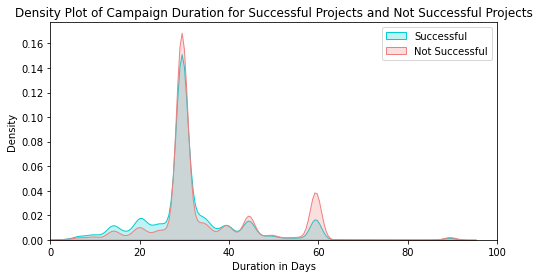

Mean:  33.578703520269215
Mode:  29
Median:  30.0


,state
currency,0.067287
goal,0.049425
state,1.000000
country,0.065667
usd_goal_real,0.047103
tlength,0.065414
duration,0.118977
lmonth,0.019458
lday,0.018731
dmonth,0.006691


In [17]:
# DATA ANALYSIS AFTER FEATURE ENGINEERING
# TODO: do more data analysis here

# plot project duration
plt.figure(figsize=(8,4))
ax = sns.kdeplot(data['duration'][data.state == 1], color="darkturquoise", shade=True)
sns.kdeplot(data['duration'][data.state == 0], color="lightcoral", shade=True)
plt.legend(['Successful', 'Not Successful'])
plt.title('Density Plot of Campaign Duration for Successful Projects and Not Successful Projects')
ax.set(xlabel='Duration in Days')

# maximum project duration is 92 days
plt.xlim(0,100)
plt.show()

# print statistical data
print("Mean: ", data['duration'].mean())
print("Mode: ", data['duration'].mode()[0])
print("Median: ", data['duration'].median())

# correlations
data.corr().abs()[['state']]


------------------------------------------------------------


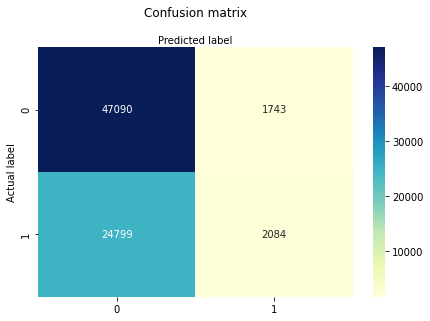

------------------------------------------------------------
Accuracy: 64.95%
Precision: 54.46%
Recall: 7.752111%
------------------------------------------------------------
Logistic regression score for training set: 65.10%
Logistic regression score for test set: 64.94%
------------------------------------------------------------
Classification report:
              precision    recall  f1-score   support

           0       0.66      0.96      0.78     48833
           1       0.54      0.08      0.14     26883

    accuracy                           0.65     75716
   macro avg       0.60      0.52      0.46     75716
weighted avg       0.62      0.65      0.55     75716

------------------------------------------------------------


In [28]:
# LINEAR REGRESSION
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split as split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn import metrics

# make sure our data looks right
data.describe(include = 'all')

# x: predictors
# y: outcome

# get predictors and outcome
x_unscaled = data.drop('state', axis=1)
y = data.state # state is 0 or 1, so already scaled

# feature scaling
scaler = StandardScaler()
x = pd.DataFrame(scaler.fit_transform(x_unscaled), columns=list(x_unscaled.columns))

# split data set int training and testing 
# test_size = proportion of dataset to include in the test split
# random_state = seed for random number generator that will shuffle the records
x_train, x_test, y_train, y_test = split(x, y, test_size=0.2, random_state=42)

# instantiate logistic regression model
logreg = LogisticRegression()

# fit the model with the data
logreg.fit(x_train,y_train)

# make predictions
y_pred_train = logreg.predict(x_train)
y_pred_test = logreg.predict(x_test)

# create confusion matrix
cnf_matrix = metrics.confusion_matrix(y_test, y_pred_test)
cnf_matrix

# visualize confusion matrix
print("-"*60)
class_names=[0,1]
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()
print("-"*60)

# confusion matrix evaluation
print('Accuracy: %.2f%%' %(metrics.accuracy_score(y_test, y_pred_test)*100))
print('Precision: %.2f%%' %(metrics.precision_score(y_test, y_pred_test)*100))
print('Recall: %.2f%%' %(metrics.recall_score(y_test, y_pred_test)*100))
print("-"*60)

# logistic regression scores
print('Logistic regression score for training set: %.2f%%' %(round(logreg.score(x_train, y_train),5)*100))
print('Logistic regression score for test set: %.2f%%' %(round(logreg.score(x_test, y_test),5)*100))
print("-"*60)

# classification report
print("Classification report:")
print(classification_report(y_test, y_pred_test))
print("-"*60)

